In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'vehicle-claim-fraud-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1807255%2F2947792%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240802%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240802T151755Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5eab95def4db811a652d8d37d61e9912803a05dd6560c5483dd785c903b9b54169af12e7de9e24930cc5e8853839bfe0fcc23fe3806566eff3f706e2d20d1d4b870c34b8c9821b6ac0b90acc632ffdb36fe5356d5638b390c77ea96b475c8206ae7a57ab3d1a10e9d94e24ded3595430511aa75ba6a068861843aa06d52482970210df212a55ee1cd26764a671451e04015dccda98d9819786495321ce17a5fe2e9c590dc3483e925e1c85f2649e2d895f5dcc8b456c329e0de9e1059ce11b4308cff08b476a423215b24187136ac07ef160d851e99e3a04aed2341798c1b601a83ed0cebd4a6d7099660f115c036d608fb5f6ca26109f6571e6196441b934a0'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)



[==================================================] 356667 bytes downloaded
Downloaded and uncompressed: vehicle-claim-fraud-detection
Data source import complete.


In [1]:

import numpy as np
import pandas as pd



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



# 📊**01. Descriptive Analysis**📊

In [ ]:
raw_data = pd.read_csv('/kaggle/input/vehicle-claim-fraud-detection/fraud_oracle.csv')
raw_data.shape

(15420, 33)

In [ ]:
# Set-up
pd.set_option('display.max_columns', None)

In [ ]:
raw_data.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,20000 to 29000,0,4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,more than 69000,0,5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


## 02) Missing Values

<Axes: >

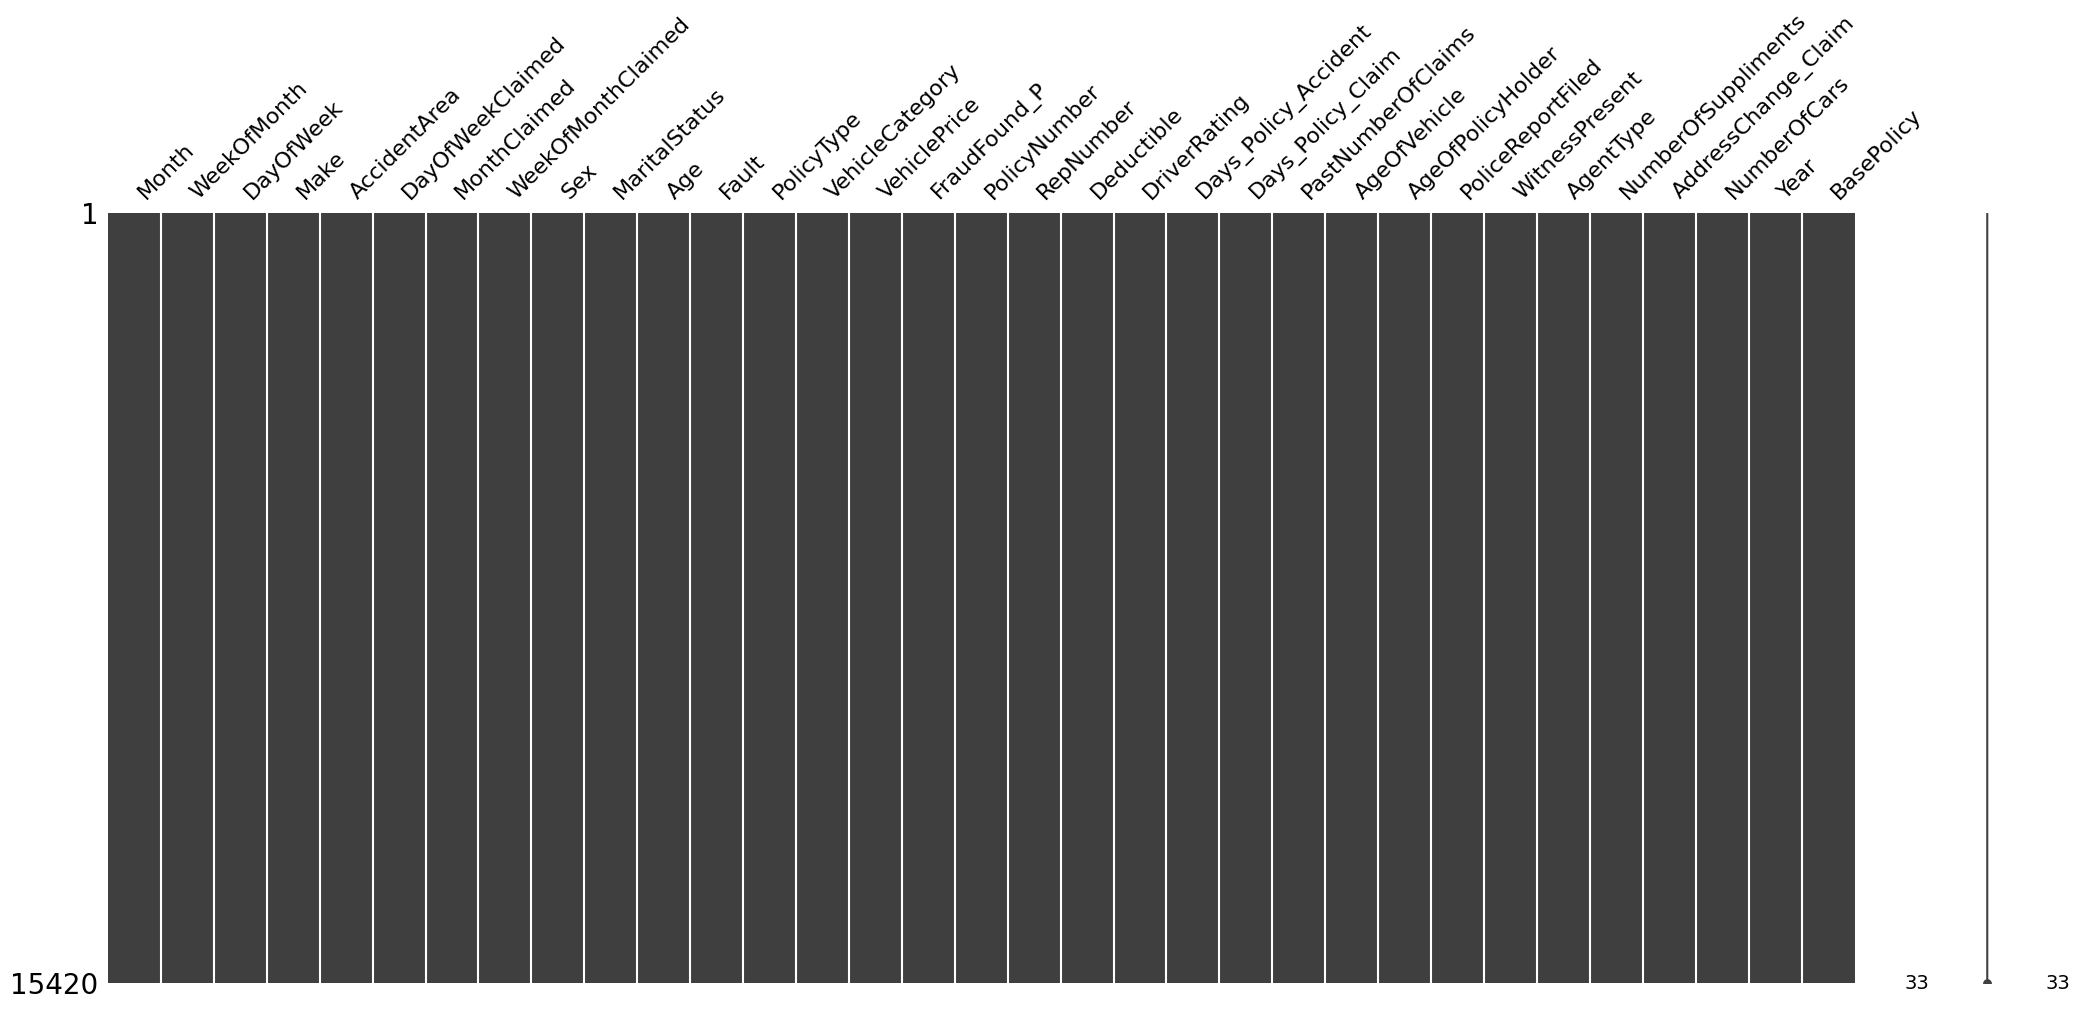

In [ ]:
msno.matrix(raw_data)

#### **Point 01**: There is no missing value.

## 03) Characteristic of Dataset

In [ ]:
# Function01: Summarize the characteristic of dataset
def summarize(DataFrame):

    summary = pd.DataFrame()

    # Data Type
    summary['Data Type'] = DataFrame.dtypes
    # N Unique
    summary['N Unique'] = DataFrame.nunique()
    # Unique
    summary['Unique'] = DataFrame.apply(lambda x: x.unique().tolist())
    # Max
    summary['Max'] = DataFrame.apply(lambda x: x.max() if pd.api.types.is_numeric_dtype(x) else '-')
    # Min
    summary['Min'] = DataFrame.apply(lambda x: x.min() if pd.api.types.is_numeric_dtype(x) else '-')

    # Measures of Central Tendency: Mean, Median, Mode
    summary['Mean'] = DataFrame.apply(lambda x: round(x.mean(), 2) if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Median'] = DataFrame.apply(lambda x: x.median() if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Mode'] = DataFrame.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else '-')

    # Measures of Dispersion: Range, Variance, Standard Deviation
    summary['Range'] = DataFrame.apply(lambda x: x.max() - x.min() if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Variance'] = DataFrame.apply(lambda x: x.var() if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Standard Deviation'] = DataFrame.apply(lambda x: x.std() if pd.api.types.is_numeric_dtype(x) else '-')

    # Measures of Shape: Skewness, Kurtosis
    summary['Skewness'] = DataFrame.apply(lambda x: round(x.skew(), 2) if pd.api.types.is_numeric_dtype(x) else '-')
    summary['Kurtosis'] = DataFrame.apply(lambda x: round(x.kurt(), 2) if pd.api.types.is_numeric_dtype(x) else '-')

    return summary

In [ ]:
summary = summarize(raw_data)
summary

,Data Type,N Unique,Unique,Max,Min,Mean,Median,Mode,Range,Variance,Standard Deviation,Skewness,Kurtosis
Month,object,12,"[Dec, Jan, Oct, Jun, Feb, Nov, Apr, Mar, Aug, ...",-,-,-,-,Jan,-,-,-,-,-
WeekOfMonth,int64,5,"[5, 3, 2, 4, 1]",5,1,2.79,3.0,3,4,1.657876,1.287585,0.12,-1.1
DayOfWeek,object,7,"[Wednesday, Friday, Saturday, Monday, Tuesday,...",-,-,-,-,Monday,-,-,-,-,-
Make,object,19,"[Honda, Toyota, Ford, Mazda, Chevrolet, Pontia...",-,-,-,-,Pontiac,-,-,-,-,-
AccidentArea,object,2,"[Urban, Rural]",-,-,-,-,Urban,-,-,-,-,-
DayOfWeekClaimed,object,8,"[Tuesday, Monday, Thursday, Friday, Wednesday,...",-,-,-,-,Monday,-,-,-,-,-
MonthClaimed,object,13,"[Jan, Nov, Jul, Feb, Mar, Dec, Apr, Aug, May, ...",-,-,-,-,Jan,-,-,-,-,-
WeekOfMonthClaimed,int64,5,"[1, 4, 2, 3, 5]",5,1,2.69,3.0,2,4,1.585371,1.259115,0.16,-1.09
Sex,object,2,"[Female, Male]",-,-,-,-,Male,-,-,-,-,-
MaritalStatus,object,4,"[Single, Married, Widow, Divorced]",-,-,-,-,Married,-,-,-,-,-


In [ ]:
df_viz = raw_data.copy()
df_viz.shape

(15420, 33)

In [ ]:
fraud_counts = df_viz['FraudFound_P'].value_counts().reset_index()
fraud_counts.columns = ['FraudFound_P', 'Count']
fraud_counts

,FraudFound_P,Count
0,0,14497
1,1,923


In [ ]:
# Pie Chart
fig = px.pie(fraud_counts, names='FraudFound_P', values='Count', color='FraudFound_P',
            color_discrete_map={0: '#87CEFA', 1:'FF6F61'})

fig.update_traces(
    textinfo='percent',
    textfont={'size': 16, 'color': 'Black'},
    marker=dict(line=dict(color='black', width=2)))

fig.update_layout(
    title={
        'text': 'Target Balance',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    })

fig.show()

In [ ]:
df_fraud = df_viz[df_viz['FraudFound_P'] == 1]

fraud_counts_sex = df_fraud['Sex'].value_counts()
fraud_percentages_sex = (fraud_counts_sex / fraud_counts_sex.sum()) * 100
fraud_percentages_sex

# Bar Chart
fig = go.Figure()

fig.add_trace(go.Bar(x=fraud_counts_sex.index, y=fraud_counts_sex.values,
                    text=[f'{count} ({percentage:.2f}%)' for count, percentage in zip(fraud_counts_sex.values, fraud_percentages_sex)],
                    textposition='auto', marker_color=['rgba(31, 119, 180, 0.6)', 'rgba(255, 127, 14, 0.6)'], width=0.5))

fig.update_layout(
    title={
        'text': 'Fraud Detection by Age',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    })

fig.update_layout(
    xaxis=dict(title='Sex'),
    yaxis=dict(title='Count'),
    showlegend=False)

fig.show()

In [ ]:
df_fraud = df_viz[df_viz['FraudFound_P'] == 1]
df_non_fraud = df_viz[df_viz['FraudFound_P'] == 0]

df_counts_age = df_viz['Age'].value_counts().sort_index()
df_counts_fraud = df_fraud['Age'].value_counts().sort_index()

df_percentages_fraud = round((df_counts_fraud / df_counts_age) * 100, 2)

# Bar Chart
fig = go.Figure()

fig.add_trace(go.Bar(x=df_percentages_fraud.index, y=df_percentages_fraud.values,
    marker_color='rgba(31, 119, 180, 0.7)'))

fig.update_layout(
    title={
        'text': 'Fraud Detection by Age',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    })

fig.update_layout(
    xaxis=dict(title='Age'), yaxis=dict(title='Percentage', range=[0, 20], dtick=2), legend=dict(title='Outcome'))

fig.add_shape(
    type="line",
    x0=min(df_percentages_fraud.index),
    y0=6,
    x1=max(df_percentages_fraud.index),
    y1=6,
    line=dict(
        color="rgba(255, 0, 0, 0.8)",
        width=2,
        dash="dashdot",
    ),
)

fig.show()

In [ ]:
df_fraud = df_viz[df_viz['FraudFound_P'] == 1]
df_non_fraud = df_viz[df_viz['FraudFound_P'] == 0]

df_counts_ageofpolicyholder = df_viz['AgeOfPolicyHolder'].value_counts().sort_index()
df_counts_fraud_ = df_fraud['AgeOfPolicyHolder'].value_counts().sort_index()

df_percentages_fraud_ = round((df_counts_fraud_ / df_counts_ageofpolicyholder) * 100, 2)

# Bar Chart
fig = go.Figure()

fig.add_trace(go.Bar(x=df_percentages_fraud_.index, y=df_percentages_fraud_.values,
    marker_color='rgba(31, 119, 180, 0.7)'))

fig.update_layout(
    title={
        'text': 'Fraud Detection by Age of Policy Holder',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    })

fig.update_layout(
    xaxis=dict(title='Age of Policy Holder'), yaxis=dict(title='Percentage', range=[0, 20], dtick=2), legend=dict(title='Outcome'))

fig.add_shape(
    type="line",
    x0=-1,
    y0=6,
    x1=10,
    y1=6,
    line=dict(
        color="rgba(255, 0, 0, 0.8)",
        width=2,
        dash="dashdot",
    ),
)

fig.show()

In [ ]:
df_counts_make = df_viz['Make'].value_counts().sort_index()
df_counts_fraud2 = df_fraud['Make'].value_counts().sort_index()
df_percentages_fraud2 = pd.DataFrame(round((df_counts_fraud2 / df_counts_make) * 100, 2)).fillna(0).reset_index()

df_percentages_fraud2.columns = ['Make', 'Fraud %']
df_percentages_fraud2 = df_percentages_fraud2.sort_values(by=['Fraud %', 'Make'])

# Bar Chart
fig = go.Figure()

fig.add_trace(go.Bar(x=df_percentages_fraud2['Fraud %'], y=df_percentages_fraud2['Make'], orientation='h',
    marker_color='lightcoral'))

fig.update_layout(
    title={
        'text': 'Fraud Detection by Make',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    })

fig.update_layout(
    xaxis=dict(title='Percentage', range=[0, 30], dtick=2), yaxis=dict(title='Make'), legend=dict(title='Outcome'), bargap=0.3)

fig.add_shape(
    type="line",
    x0=6,
    y0=0,
    x1=6,
    y1=len(df_percentages_fraud2['Make']) - 1,
    line=dict(
        color="rgba(128, 128, 128, 1)",
        width=2,
        dash="dashdot",
    ),
)

fig.show()

In [ ]:
df_counts_vp = df_viz['VehiclePrice'].value_counts().sort_index()
df_counts_fraud3 = df_fraud['VehiclePrice'].value_counts().sort_index()
df_percentages_fraud3 = pd.DataFrame(round((df_counts_fraud3 / df_counts_vp) * 100, 2)).fillna(0).reset_index()

df_percentages_fraud3.columns = ['VehiclePrice', 'Fraud %']
df_percentages_fraud3 = df_percentages_fraud3.sort_values(by=['Fraud %'])

# Bar Chart
fig = go.Figure()

fig.add_trace(go.Bar(x=df_percentages_fraud3['Fraud %'], y=df_percentages_fraud3['VehiclePrice'], orientation='h',
    marker_color='#9FF781'))

fig.update_layout(
    title={
        'text': 'Fraud Detection by VehiclePrice',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    })

fig.update_layout(
    xaxis=dict(title='Percentage', range=[0, 16], dtick=2), yaxis=dict(title='VehiclePrice'), legend=dict(title='Outcome'), bargap=0.3)

fig.add_shape(
    type="line",
    x0=6,
    y0=0,
    x1=6,
    y1=5.5,
    line=dict(
        color="rgba(0, 100, 0, 1)",
        width=2,
        dash="dashdot",
    ),
)

fig.show()

In [ ]:
# BasePolicy
df_counts_policy = df_viz['BasePolicy'].value_counts().sort_index()
df_counts_fraud4 = df_fraud['BasePolicy'].value_counts().sort_index()
df_percentages_fraud4 = pd.DataFrame(round((df_counts_fraud4 / df_counts_policy) * 100, 2)).fillna(0).reset_index()

df_percentages_fraud4.columns = ['BasePolicy', 'Fraud %']
df_percentages_fraud4 = df_percentages_fraud4.sort_values(by=['Fraud %'])

# PolicyType
df_counts_policy2 = df_viz['PolicyType'].value_counts().sort_index()
df_counts_fraud5 = df_fraud['PolicyType'].value_counts().sort_index()
df_percentages_fraud5 = pd.DataFrame(round((df_counts_fraud5 / df_counts_policy2) * 100, 2)).fillna(0).reset_index()

df_percentages_fraud5.columns = ['PolicyType', 'Fraud %']
df_percentages_fraud5 = df_percentages_fraud5.sort_values(by=['Fraud %'])

# Bar Chart - Subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=('BasePolicy', "PolicyType"))

fig.add_trace(go.Bar(x=df_percentages_fraud4['BasePolicy'], y=df_percentages_fraud4['Fraud %'],
    marker_color='skyblue'), row=1, col=1)

fig.add_trace(go.Bar(x=df_percentages_fraud5['PolicyType'], y=df_percentages_fraud5['Fraud %'],
    marker_color='coral'), row=1, col=2)

fig.update_layout(
    title={
        'text': 'Fraud Detection by BasePolicy & PolicyType',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    }, showlegend=False)

fig.add_shape(
    type="line",
    x0=-1,
    y0=6,
    x1=3,
    y1=6,
    line=dict(
        color="rgba(128, 128, 128, 1)",
        width=2,
        dash="dashdot",
    ),
    xref="x1",
    yref="y1"
)

fig.add_shape(
    type="line",
    x0=-1,
    y0=6,
    x1=9,
    y1=6,
    line=dict(
        color="rgba(128, 128, 128, 1)",
        width=2,
        dash="dashdot",
    ),
    xref="x2",
    yref="y2"
)

fig.show()

In [ ]:
# Age of Vehicle
df_counts_ageofvehicle = df_viz['AgeOfVehicle'].value_counts().sort_index()
df_counts_fraud6 = df_fraud['AgeOfVehicle'].value_counts().sort_index()
df_percentages_fraud6 = pd.DataFrame(round((df_counts_fraud6 / df_counts_ageofvehicle) * 100, 2)).fillna(0).reset_index()

df_percentages_fraud6.columns = ['AgeOfVehicle', 'Fraud %']
df_percentages_fraud6 = df_percentages_fraud6.sort_values(by=['Fraud %'])

# Bar Chart
fig = go.Figure()

fig.add_trace(go.Bar(x=df_percentages_fraud6['Fraud %'], y=df_percentages_fraud6['AgeOfVehicle'], orientation='h',
    marker_color='rgb(255, 165, 0)'))

fig.update_layout(
    title={
        'text': 'Fraud Detection by Age of Vehicle',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    })

fig.update_layout(
    xaxis=dict(title='Percentage', range=[0, 16], dtick=2), yaxis=dict(title='AgeOfVehicle'), legend=dict(title='Outcome'), bargap=0.3)

fig.add_shape(
    type="line",
    x0=6,
    y0=-1,
    x1=6,
    y1=8,
    line=dict(
        color="rgba(0, 100, 0, 1)",
        width=2,
        dash="dashdot",
    ),
)

fig.show()

In [ ]:
# Month
df_counts_month = df_viz['Month'].value_counts().sort_index()
df_counts_fraud7 = df_fraud['Month'].value_counts().sort_index()
df_percentages_fraud7 = pd.DataFrame(round((df_counts_fraud7 / df_counts_month) * 100, 2)).fillna(0).reset_index()

df_percentages_fraud7.columns = ['Month', 'Fraud %']

# MonthClaimed
df_counts_monthclaimed = df_viz['MonthClaimed'].value_counts().sort_index()
df_counts_fraud8 = df_fraud['MonthClaimed'].value_counts().sort_index()
df_percentages_fraud8 = pd.DataFrame(round((df_counts_fraud8 / df_counts_monthclaimed) * 100, 2)).fillna(0).reset_index()

df_percentages_fraud8.columns = ['MonthClaimed', 'Fraud %']

month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Bar Chart - Subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=('Month', "MonthClaimed"))

fig.add_trace(go.Bar(x=df_percentages_fraud7['Month'], y=df_percentages_fraud7['Fraud %'],
    marker_color='#8A2BE2'), row=1, col=1)

fig.add_trace(go.Bar(x=df_percentages_fraud8['MonthClaimed'], y=df_percentages_fraud8['Fraud %'],
    marker_color='#FF4500'), row=1, col=2)

fig.update_layout(
    title={
        'text': 'Fraud Detection by Month & MonthClaimed',
        'x':0.5,
        'font': {'family': "Arial, sans-serif", 'size': 24}
    }, showlegend=False,
    xaxis=dict(categoryorder='array', categoryarray=month_order),
    xaxis2=dict(categoryorder='array', categoryarray=month_order))

fig.add_shape(
    type="line",
    x0=-1,
    y0=6,
    x1=12,
    y1=6,
    line=dict(
        color="rgba(128, 128, 128, 1)",
        width=2,
        dash="dashdot",
    ),
    xref="x1",
    yref="y1"
)

fig.add_shape(
    type="line",
    x0=-1,
    y0=6,
    x1=12.5,
    y1=6,
    line=dict(
        color="rgba(128, 128, 128, 1)",
        width=2,
        dash="dashdot",
    ),
    xref="x2",
    yref="y2"
)

fig.show()

In [ ]:
df_clean_v1 = raw_data.copy()
df_clean_v1.shape

(15420, 33)

In [ ]:
binary_columns = [col for col in df_clean_v1.columns if df_clean_v1[col].nunique() == 2 and col != 'FraudFound_P']

In [ ]:
print('The number of Binary Columns: ', len(binary_columns))
print('Binary Columns: ', binary_columns)

The number of Binary Columns:  6
Binary Columns:  ['AccidentArea', 'Sex', 'Fault', 'PoliceReportFiled', 'WitnessPresent', 'AgentType']


In [ ]:
le = LabelEncoder()

for col  in binary_columns:
    df_clean_v1[col] = le.fit_transform(df_clean_v1[col])
    print('Label Mapping: ', dict(zip(le.classes_, le.transform(le.classes_))))

Label Mapping:  {'Rural': 0, 'Urban': 1}
Label Mapping:  {'Female': 0, 'Male': 1}
Label Mapping:  {'Policy Holder': 0, 'Third Party': 1}
Label Mapping:  {'No': 0, 'Yes': 1}
Label Mapping:  {'No': 0, 'Yes': 1}
Label Mapping:  {'External': 0, 'Internal': 1}


In [ ]:
for col in ['VehiclePrice', 'DriverRating', 'AgeOfVehicle', 'BasePolicy']:
    print(f"The unique values in {col}: {df_clean_v1[col].unique()}")

The unique values in VehiclePrice: ['more than 69000' '20000 to 29000' '30000 to 39000' 'less than 20000'
 '40000 to 59000' '60000 to 69000']
The unique values in DriverRating: [1 4 3 2]
The unique values in AgeOfVehicle: ['3 years' '6 years' '7 years' 'more than 7' '5 years' 'new' '4 years'
 '2 years']
The unique values in BasePolicy: ['Liability' 'Collision' 'All Perils']


In [ ]:
vehicleprice_label = {'more than 69000': 1, '20000 to 29000': 0,  '30000 to 39000': 0, 'less than 20000': 1, '40000 to 59000': 1, '60000 to 69000': 0}
ageofvehicle_label = {'new': 2, '2 years': 0, '3 years': 2, '4 years': 2, '5 years': 1, '6 years': 1, '7 years': 0, 'more than 7': 0}
basepolicy_label = {'Liability': 0, 'Collision': 1, 'All Perils': 2}

In [ ]:
df_clean_v1['VehiclePrice'] = df_clean_v1['VehiclePrice'].map(vehicleprice_label)
df_clean_v1['AgeOfVehicle'] = df_clean_v1['AgeOfVehicle'].map(ageofvehicle_label)
df_clean_v1['BasePolicy'] = df_clean_v1['BasePolicy'].map(basepolicy_label)

In [ ]:
df_clean_v2 = df_clean_v1.copy()
df_clean_v2.shape

(15420, 33)

In [ ]:
useless_columns = ['Month', 'WeekOfMonth', 'DayOfWeek', 'DayOfWeekClaimed', 'WeekOfMonthClaimed', 'PolicyNumber']
df_clean_v3 = df_clean_v2.drop(columns=useless_columns, axis=1)
df_clean_v3.shape

(15420, 27)

In [ ]:
dtype_change_string = ['RepNumber', 'Deductible', 'Year']

for col in dtype_change_string:
    df_clean_v3[col] = df_clean_v3[col].astype(str)

In [ ]:
onehot_encoding_columns = ['Make', 'MonthClaimed', 'MaritalStatus', 'PolicyType', 'VehicleCategory', 'RepNumber', 'Deductible', 'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfPolicyHolder', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year']
print("The number of one-hot encoding target features: ", len(onehot_encoding_columns))

The number of one-hot encoding target features:  15


In [ ]:
df_clean_v4 = pd.get_dummies(df_clean_v3, columns=onehot_encoding_columns)
df_clean_v4.shape

(15420, 119)

In [ ]:
onehot_encoded_columns = [col for col in df_clean_v4.columns if '_' in col]
onehot_encoded_columns.remove("FraudFound_P")
print("The Number of One-hot Encoded Columns: ", len(onehot_encoded_columns))

The Number of One-hot Encoded Columns:  107


In [ ]:
constant_features = []
for col in onehot_encoded_columns:
    if df_clean_v4[col].sum() <= 5:
        constant_features.append(col)
print("The Number of Constant Features: ", len(constant_features))

The Number of Constant Features:  9


In [ ]:
df_clean_v4.drop(columns=constant_features, axis=1, inplace=True)
df_clean_v4.shape

(15420, 110)

In [ ]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Histogram of Age", "Box Plot of Age"))

# Histogram
fig.add_trace(go.Histogram(x=df_viz['Age'], nbinsx=100), row=1, col=1)
# Box Plot
fig.add_trace(go.Box(x=df_viz['Age']), row=1, col=2)

fig.update_layout(
    title={
        'text': 'Distribution of Age', 'x':0.5,
        'xanchor': 'center', 'yanchor': 'top',
        'font': {'family': 'Arial, sans-serif', 'size': 24}
    }, showlegend=False
)

fig.show()

In [ ]:
# Function02: Outlier Replacement using LightGBM
def lightgbm_imputation(dataframe, feature):
    df_copy = dataframe.copy()
    train_data = df_copy[df_copy[feature].notnull()]
    test_data = df_copy[df_copy[feature].isnull()]

    X_train = train_data.drop(columns=[feature], axis=1)
    y_train = train_data[feature]
    X_test = test_data.drop(columns=[feature], axis=1)

    train_dataset = lgb.Dataset(X_train, label=y_train)

    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbose': -1
    }

    model = lgb.train(params, train_dataset, num_boost_round=100)

    predictions = model.predict(X_test)

    df_copy.loc[df_copy[feature].isnull(), feature] = predictions

    return df_copy

In [ ]:
# Change 0s and outliers into NullValues
df_clean_v4['Age'] = df_clean_v4['Age'].apply(lambda x: np.nan if x == 0 or x > 74 else x)

In [ ]:
# Apply LightGBM Imputation
df_imputed = lightgbm_imputation(df_clean_v4, 'Age')

In [ ]:
# Round up floats
df_imputed['Age'] = df_imputed["Age"].apply(lambda x: round(x))

#### After I finished the work, I transoformed the continuous variable into categorial variable based on the **Visualization 3**.

In [ ]:
# Function03: Categorize Age
def categorize_age(age):
    if age <= 20:
        return 0
    elif age <= 40:
        return 1
    elif age <= 65:
        return 2
    else:
        return 3

In [ ]:
df_imputed['Age'] = df_imputed['Age'].apply(categorize_age)

In [ ]:
df_clean_v5 = df_imputed.copy()
df_clean_v5.shape

(15420, 110)

![SMOTE Oversampling.webp](attachment:009bd2a0-1f43-411b-9751-75e2148096ea.webp)

* **Image Source**: https://medium.com/@asheshdas.ds/oversampling-to-remove-class-imbalance-using-smote-94d5648e7d35

In [ ]:
# Train - Test Split
X = df_clean_v5.drop(columns="FraudFound_P")
y = df_clean_v5["FraudFound_P"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

print("Before SMOTE: ", X_train.shape, y_train.shape)
print("After Smote: ", X_train_over.shape, y_train_over.shape)
print()
print("After SMOTE Label Distribution: ", pd.Series(y_train_over).value_counts())

Before SMOTE:  (12336, 109) (12336,)
After Smote:  (23220, 109) (23220,)

After SMOTE Label Distribution:  FraudFound_P
0    11610
1    11610
Name: count, dtype: int64


In [ ]:
df_smote = pd.concat([X_train_over, y_train_over], axis=1)
df_smote.shape

(23220, 110)

In [ ]:
X_smote = df_smote.drop(columns="FraudFound_P")
y_smote = df_smote["FraudFound_P"]
print(X_smote.shape, y_smote.shape)

(23220, 109) (23220,)


In [ ]:
# VarianceThreshold
selector = VarianceThreshold(threshold=0.01) # The larger the threshold, the more features are eliminated.
X_reduced = selector.fit_transform(X_smote)
X_reduced.shape

(23220, 82)

In [ ]:
selected_feature_indices = selector.get_support(indices=True)
selected_feature_names = X_smote.columns[selected_feature_indices]
X_reduced = pd.DataFrame(X_reduced, columns=selected_feature_names)

#### **Now, let's play with RFECV!**

In [ ]:
# LigthGBM
lightgbm_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)

In [ ]:
rfecv = RFECV(estimator=lightgbm_model, step=1, cv=StratifiedKFold(5), scoring='roc_auc', n_jobs=-1)
rfecv.fit(X_reduced, y_smote)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(random_state=42, verbose=-1), n_jobs=-1,
      scoring='roc_auc')

In [ ]:
# The Selected features
optimal_num_features =rfecv.n_features_
print(f"Optimal number of features: {optimal_num_features}")

Optimal number of features: 62


In [ ]:
X_selected = rfecv.transform(X_reduced)

In [ ]:
selected_feature_indices = np.where(rfecv.support_)[0]
selected_feature_names = X_reduced.columns[selected_feature_indices]
X_rfecv = pd.DataFrame(X_selected, columns=selected_feature_names)

In [ ]:
# X_rfecv_test
rfecv_columns = X_rfecv.columns.tolist()
X_rfecv_test = X_test[rfecv_columns]

In [ ]:
# Function04: Objective
def objective(trial):
    classifier_name = trial.suggest_categorical('classifier', [
        'LogisticRegression', 'SVM', 'KNeighbors', 'RandomForest', 'LightGBM', 'CatBoost'
    ])

    if classifier_name == 'LogisticRegression':
        C = trial.suggest_float('lr_C', 0.1, 10)
        solver = trial.suggest_categorical('lr_solver', ['liblinear'])
        classifier_obj = LogisticRegression(C=C, solver=solver)

    elif classifier_name == 'SVM':
        C = trial.suggest_float('svm_C', 0.1, 10)
        kernel = trial.suggest_categorical('svm_kernel', ['linear', 'rbf'])
        classifier_obj = SVC(C=C, kernel=kernel, probability=True)

    elif classifier_name == 'KNeighbors':
        n_neighbors = trial.suggest_int('kn_n_neighbors', 3, 7)
        classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)

    elif classifier_name == 'RandomForest':
        n_estimators = trial.suggest_int('rf_n_estimators', 100, 200)
        max_depth = trial.suggest_categorical('rf_max_depth', [10, 20, None])
        classifier_obj = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)

    elif classifier_name == 'LightGBM':
        num_leaves = trial.suggest_int('lgb_num_leaves', 31, 50)
        learning_rate = trial.suggest_float('lgb_learning_rate', 0.01, 0.2)
        n_estimators = trial.suggest_int('lgb_n_estimators', 100, 200)
        classifier_obj = lgb.LGBMClassifier(num_leaves=num_leaves, learning_rate=learning_rate, n_estimators=n_estimators, verbose=-1)

    elif classifier_name == 'CatBoost':
        iterations = trial.suggest_int('cat_iterations', 100, 200)
        learning_rate = trial.suggest_float('cat_learning_rate', 0.01, 0.2)
        depth = trial.suggest_int('cat_depth', 3, 9)
        classifier_obj = CatBoostClassifier(iterations=iterations, learning_rate=learning_rate, depth=depth, verbose=0)

    classifier_obj.fit(X_rfecv, y_smote)
    y_prob = classifier_obj.predict_proba(X_rfecv_test)[:, 1]

    # Threshold optimization
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_threshold = 0.5
    best_score = 0.0

    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        score = f1_score(y_test, y_pred)
        if score > best_score:
            best_score = score
            best_threshold = threshold

    trial.set_user_attr('best_threshold', best_threshold)
    trial.set_user_attr('classifier_obj', classifier_obj)
    return roc_auc_score(y_test, (y_prob >= best_threshold).astype(int))

In [ ]:
# Optuna Study
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=100)

In [ ]:
best_trial = study.best_trial
print('Best trial: ', best_trial.values)
print('Best hyperparameters: ', best_trial.params)

In [ ]:
# Optimized Alogrithm Combination
best_algorithms = [trial.params['classifier'] for trial in study.trials]
algorithm_counts = pd.Series(best_algorithms).value_counts()
print('Optimal algorithm proportions: ', algorithm_counts)

In [ ]:
# Function05: Evaluation
def evaluate_model(model, X_train, y_train, X_test, y_test, threshold):
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)[:, 1]
    y_pred = (y_prob >= threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    return accuracy, precision, recall, f1, roc_auc

In [ ]:
top_5_trials = study.trials_dataframe().sort_values(by='value', ascending=False).head(5)
results = []

for i, row in top_5_trials.iterrows():
    model_name = row['params_classifier']
    threshold = study.trials[row['number']].user_attrs['best_threshold']
    model_params = study.trials[row['number']].params

    if model_name == 'LogisticRegression':
        params = {'C': model_params['lr_C'], 'solver': model_params['lr_solver']}
        final_model = LogisticRegression(**params)
    elif model_name == 'SVM':
        params = {'C': model_params['svm_C'], 'kernel': model_params['svm_kernel']}
        final_model = SVC(**params, probability=True)
    elif model_name == 'KNeighbors':
        params = {'n_neighbors': model_params['kn_n_neighbors']}
        final_model = KNeighborsClassifier(**params)
    elif model_name == 'RandomForest':
        params = {'n_estimators': model_params['rf_n_estimators'], 'max_depth': model_params['rf_max_depth']}
        final_model = RandomForestClassifier(**params)
    elif model_name == 'LightGBM':
        params = {'num_leaves': model_params['lgb_num_leaves'], 'learning_rate': model_params['lgb_learning_rate'], 'n_estimators': model_params['lgb_n_estimators']}
        final_model = lgb.LGBMClassifier(**params, verbose=-1)
    elif model_name == 'CatBoost':
        params = {'iterations': model_params['cat_iterations'], 'learning_rate': model_params['cat_learning_rate'], 'depth': model_params['cat_depth']}
        final_model = CatBoostClassifier(**params, verbose=0)

    accuracy, precision, recall, f1, roc_auc = evaluate_model(final_model, X_rfecv, y_smote, X_rfecv_test, y_test, threshold)

    results.append({
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'best_params': params,
        'best_threshold': threshold
    })

results_df = pd.DataFrame(results)

In [ ]:
results_df

In [ ]:
best_model_info = results_df.iloc[0]
best_model = best_model_info['model']
best_model_params = best_model_info['best_params']
best_threshold = best_model_info['best_threshold']

final_model = None
if best_model == 'LogisticRegression':
    final_model = LogisticRegression(**best_model_params)
elif best_model == 'SVM':
    final_model = SVC(**best_model_params, probability=True)
elif best_model == 'KNeighbors':
    final_model = KNeighborsClassifier(**best_model_params)
elif best_model == 'RandomForest':
    final_model = RandomForestClassifier(**best_model_params)
elif best_model == 'LightGBM':
    final_model = lgb.LGBMClassifier(**best_model_params, verbose=-1)
elif best_model == 'CatBoost':
    final_model = CatBoostClassifier(**best_model_params, verbose=0)

final_model.fit(X_rfecv, y_smote)
result = permutation_importance(final_model, X_rfecv_test, y_test, n_repeats=10, random_state=42)
feature_importance = result.importances_mean
features = X_rfecv.columns

importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)

In [ ]:
# Select Top10 Features
top_features_df = importance_df.head(10).copy()
colors = px.colors.sequential.Plasma_r
num_colors = len(colors)
ranked_importance = top_features_df['importance'].rank(method='max', ascending=True)
color_indices = (ranked_importance / ranked_importance.max() * (num_colors - 1)).astype(int)
top_features_df.loc[:, 'color'] = color_indices.apply(lambda x: colors[x])

fig = go.Figure(go.Bar(
    x=top_features_df['importance'],
    y=top_features_df['feature'],
    orientation='h',
    marker=dict(color=top_features_df['color']),
))

fig.update_layout(
    title=f'Top 10 Feature Importance for {best_model}',
    xaxis_title='Importance',
    yaxis_title='Feature',
    yaxis=dict(autorange="reversed")
)

fig.show()